In [10]:
# 1. Import Library
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [11]:
# 2. Load Pretrained Base Model
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
print(f"Jumlah layer di base_model: {len(base_model.layers)}")

Jumlah layer di base_model: 154


In [3]:
# 3. Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(12, activation='softmax')(x)

In [4]:
# 4. Build Model
myNewModel = Model(inputs=base_model.input, outputs=predictions)

In [5]:
# 5. Freeze Layers
num_layers_to_freeze = 86
for layer in myNewModel.layers[:num_layers_to_freeze]:
    layer.trainable = False
for layer in myNewModel.layers[num_layers_to_freeze:]:
    layer.trainable = True

In [6]:
# 6. Data Generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'dataset_2/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    'dataset_2/validation',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 2607 images belonging to 12 classes.
Found 600 images belonging to 12 classes.


In [7]:
# 7. Compute Class Weights
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

In [8]:
# 8. Compile Model
opt = keras.optimizers.Adam(learning_rate=0.0001)
myNewModel.compile(optimizer=opt,
                   loss="categorical_crossentropy",
                   metrics=['accuracy'])

In [9]:
# 9. Callbacks
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [10]:
# 10. Train Model (Transfer Learning)
history = myNewModel.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    class_weight=class_weights
)

C:\Users\iksan\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.2802 - loss: 2.1538
Epoch 1: val_accuracy improved from -inf to 0.75167, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 356ms/step - accuracy: 0.2813 - loss: 2.1508 - val_accuracy: 0.7517 - val_loss: 0.7244
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7502 - loss: 0.7338
Epoch 2: val_accuracy improved from 0.75167 to 0.85500, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 335ms/step - accuracy: 0.7503 - loss: 0.7334 - val_accuracy: 0.8550 - val_loss: 0.4609
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8427 - loss: 0.4683
Epoch 3: val_accuracy did not improve from 0.85500
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 330ms/step - accuracy: 0.8428 - loss: 0.4682 - val_accuracy: 0.8383 - val_loss: 0.5220
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8821 - loss: 0.3324
Epoch 4: val_accuracy improved from 0.85500 to 0.87167, saving

In [11]:
# 11. Fine-tune Base Model
for layer in base_model.layers[-20:]:
    layer.trainable = True

myNewModel.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                   loss="categorical_crossentropy",
                   metrics=['accuracy'])

history_fine_tune = myNewModel.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    class_weight=class_weights
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9412 - loss: 0.1734
Epoch 1: val_accuracy improved from 0.91333 to 0.91833, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 346ms/step - accuracy: 0.9412 - loss: 0.1734 - val_accuracy: 0.9183 - val_loss: 0.3048
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9550 - loss: 0.1324
Epoch 2: val_accuracy improved from 0.91833 to 0.92167, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 342ms/step - accuracy: 0.9550 - loss: 0.1324 - val_accuracy: 0.9217 - val_loss: 0.2811
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9560 - loss: 0.1451
Epoch 3: val_accuracy improved from 0.92167 to 0.93333, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 338ms/step - accuracy: 0.9559 - loss: 0.1451 - val_accuracy: 0.9333 - val_loss: 0.2679
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9471 - loss: 0.1494
Epoch 4: val_accuracy

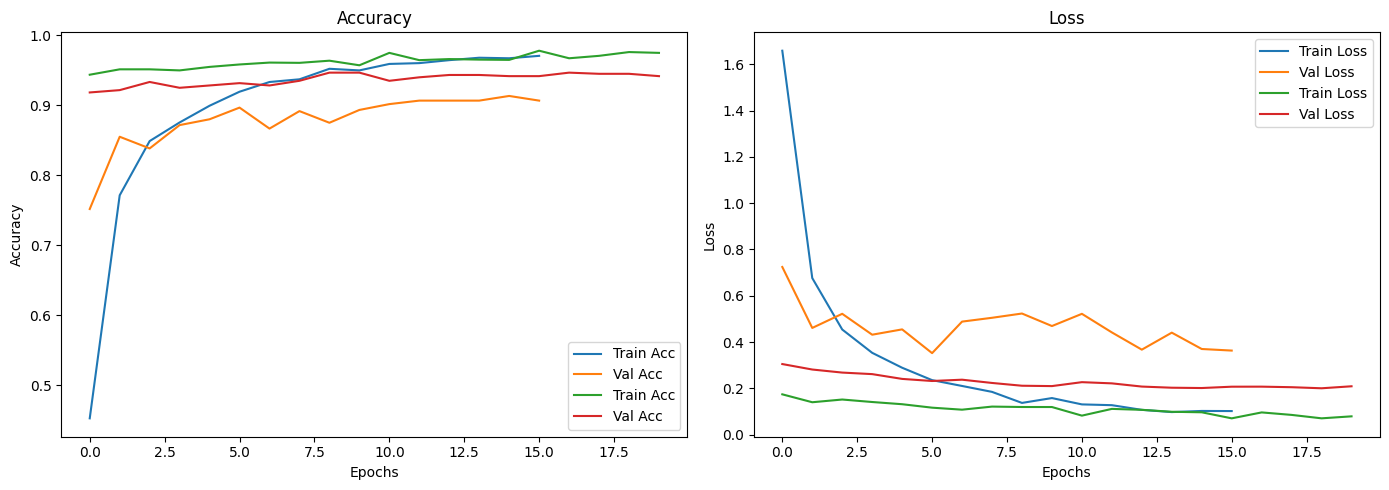

In [12]:
# 12. Plot Training History
def plot_history(histories):
    plt.figure(figsize=(14, 5))
    for history in histories:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_history([history, history_fine_tune])

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step


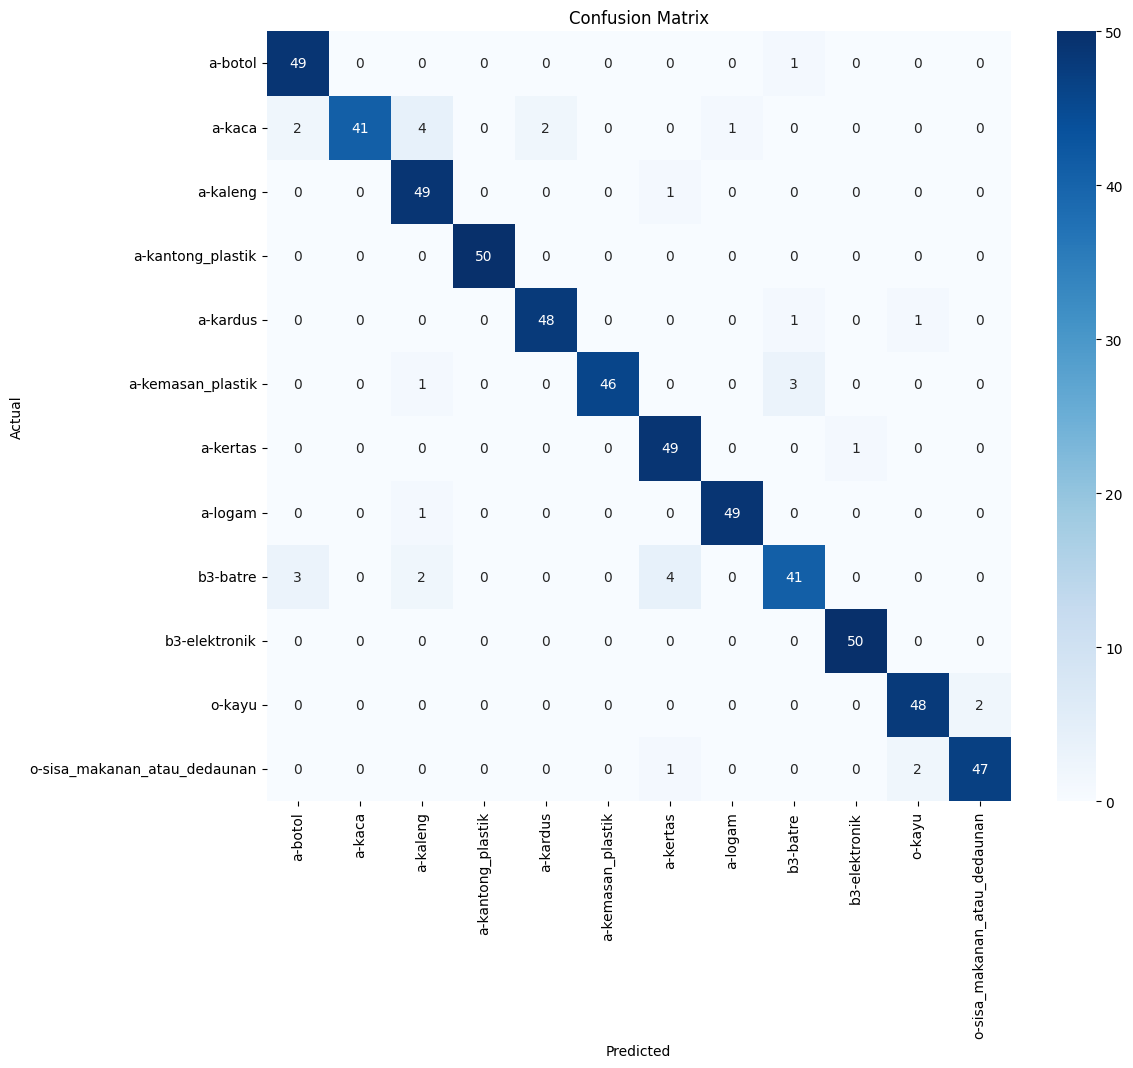

Classification Report:
                              precision    recall  f1-score   support

                     a-botol       0.91      0.98      0.94        50
                      a-kaca       1.00      0.82      0.90        50
                    a-kaleng       0.86      0.98      0.92        50
           a-kantong_plastik       1.00      1.00      1.00        50
                    a-kardus       0.96      0.96      0.96        50
           a-kemasan_plastik       1.00      0.92      0.96        50
                    a-kertas       0.89      0.98      0.93        50
                     a-logam       0.98      0.98      0.98        50
                    b3-batre       0.89      0.82      0.85        50
               b3-elektronik       0.98      1.00      0.99        50
                      o-kayu       0.94      0.96      0.95        50
o-sisa_makanan_atau_dedaunan       0.96      0.94      0.95        50

                    accuracy                           0.94      

In [13]:
# 13. Confusion Matrix & Classification Report
# Get predictions
val_preds = myNewModel.predict(validation_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = validation_generator.classes
class_names = list(validation_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [14]:
# Simpan model ke format HDF5 (.h5)
myNewModel.save('model_sampah.h5')

In [15]:
import tensorflow as tf

# Load model dari .h5
model = tf.keras.models.load_model('model_sampah.h5')

# Buat converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# # (Opsional) Untuk optimisasi ukuran model:
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi ke .tflite
tflite_model = converter.convert()

# Simpan model .tflite
with open('model_sampah.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\iksan\AppData\Local\Temp\tmpol7cl_2e\assets


INFO:tensorflow:Assets written to: C:\Users\iksan\AppData\Local\Temp\tmpol7cl_2e\assets


Saved artifact at 'C:\Users\iksan\AppData\Local\Temp\tmpol7cl_2e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  2068076796560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2068076798096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2068076798480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2068076798288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2068076795408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2068076799824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2068076800208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2068076800592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2068076800400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2068076797520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20680